# ml lesson2

依然是courses/ml/lesson1的内容。
视频时第二课。后面lesson编号根据视频来

## 首先回顾一下上一课内容

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, "F:\\fastai\\fastai1\\old\\") 

In [3]:
from fastai.imports import *
from fastai0.structured import * #代码old目录中有老版本fastai，重命名了文件夹。

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

C:\Users\kongxiangyu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
PATH = "data\\bulldozers\\"

In [5]:
df_raw = pd.read_feather('tmp/bulldozers-raw') #读取上一课保存的原始文件

In [6]:
df, y, nas = proc_df(df_raw, 'SalePrice') #数据预处理

In [7]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

lesson1讲到这里了，将数据分为测试集和验证集。

## 验证集的选择和效果评估

验证集非常重要。要选取有典型性的验证集。 representation

测试机选择了最后12000个，没有随机选择，因为数据时是时间相关的，如果随机选，训练集和验证集在时间上是重合的，容易过拟合。<p>
因为测试集是之后不同的时间的数据

In [8]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

这里计算了rmse，log在数据预处理中已经对salePrice做了转换，合起来就是RMSLE

In [20]:
y_train[:5]

array([11.09741, 10.95081,  9.21034, 10.55841,  9.30565])

score方法计算的是r-square（确定系数）
 
$$ R^2=1-\frac{SS_{res}}{SS{tot}} $$

其中，$SS_{res}$ 是Residual Sum of Squares（残差平方和）其中$\hat{y_i}$即$f_i$，表示算法的预测值 $$SS_{res}=\sum_{i=1}^n (y_i - \hat{y_i})^2=\sum_i e_i^2$$
$SS_{tot}$ 是Total Sum of Squares，再除n就是方差 其中$\overline{y}$表示y的均值 $$SS_{tot}=\sum_i (y_i - \overline{y})^2$$

r-square可以是小于1的任意数。一般来说是0-1的数。这个数越接近1，说明模型预测结果越接近真实值

如果值小于0，说明模型结果比间简单求均值还差，还不如瞎猜。。

参考：https://www.jianshu.com/p/9ee85fdad150

In [22]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 10min 41s
[0.0757920493335814, 0.23661346066887287, 0.9879944481916642, 0.9000168376154178]


可以看到，在验证集中，rmse和r-square都有降低

> 执行时间超长，估计和电脑性能有关，可能需要设置GPU，有空再研究

后面为了减少等到时间，改善交互效果，减少测试数据的量

In [9]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

在原始数据中随机取30000条数据，然后取其中前20000条，保证和验证集没有交叉

验证集不变

In [29]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 3.96 s
[0.09242412932036116, 0.38145134910667566, 0.9814890929636534, 0.7401478679746019]


由于训练数据变少，在验证集上的测试效果更差了

## 下面开始介绍random forest，从单棵树开始

In [15]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5239333695331, 0.5840917339060955, 0.4022253301126788, 0.3907295792338825]


上面创建了单棵树的模型，树的最大深度是3

然后把树画出来

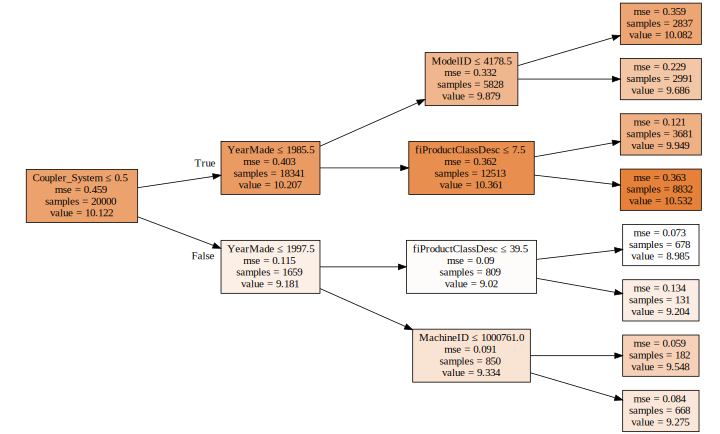

In [11]:
draw_tree(m.estimators_[0], df_trn, precision=3)

一开始这里运行出现问题了，graphviz报错。

> failed to execute ['dot', '-Kdot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

需要安装graphviz软件，参考：https://blog.csdn.net/HNUCSEE_LJK/article/details/86772806

**总结一下如何生成这个树：**
- 选一个参数
- 选一种可行的分割方式，将数据分为两部分
- 每部分计算均值(上图中的value)和MSE
- 遍历所有可能，找到一种参数+分割方法，使其加权MSE最小，然后将测试数据分为两部分
- 对于分割的两部分，继续使用上述方法，直到达到退出条件。 这个例子中退出条件就是树的深度达到3；如果没有指定深度，当其中只有一组数据时退出

如何推理y：
- 使用上面树的条件计算，直到走到某个叶子，这个叶子的均值即预测值

> 对于每一个节点分割的算法，通用方法就是用mse，一般来说效果都不错。据说也有用其它算法的，比如线性回归，但是用的比较少

## 多棵树模型

也就是课程中说的bagging

创建多颗树，每棵树的输入在测试集中随机选择, 每棵树的模型和其它树关联性尽可能小

这样每颗树得到的结果都会有随机的偏差，当把所有树的结果取平均值后，就把偏差平均掉了，最终得到的结果是可信的

> 问题：每棵树的输入随机选？数据量占测试集总量的多少？如何控制不同的树的输入不同（如果两颗树的输入雷同，那么他们的关联性就太大了，这样就做不到取平均之后能把偏差平均掉）？

In [52]:
m_multi = RandomForestRegressor(n_jobs=-1)
%time m_multi.fit(X_train, y_train)
print_score(m_multi)

Wall time: 3.79 s
[0.0924436596201881, 0.3623092380526235, 0.9813902881569985, 0.7655734536876544]


In [27]:
len(m_multi.estimators_) #缺省创建100颗树，这里叫estimator

100

下面分析每棵树得到的结果

In [32]:
preds = np.stack([t.predict(X_valid) for t in m_multi.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 9.18502,  9.3501 ,  9.15905,  9.3501 ,  9.71112,  9.3501 ,  9.25913,  9.39266,  9.21034,  9.15905,
         9.10498,  9.43348,  9.25913,  9.25913, 10.08581, 10.08581,  9.71112,  9.15905,  9.5819 ,  8.9872 ,
         9.15905,  8.95545,  9.6486 ,  9.15905,  9.61581,  9.04782,  9.51044,  9.15905,  9.10498,  9.6486 ,
         9.30565,  9.79813,  8.9359 ,  9.54681,  9.25913,  9.10498,  9.15905,  9.54681,  9.54681,  9.25913,
         8.9359 ,  9.54681,  9.18502,  9.25913,  9.3501 ,  9.15905,  9.25913,  9.30565,  8.95545,  8.9359 ,
         9.21034,  9.30565,  9.21034, 10.62133, 10.08581,  9.54681,  9.30565, 10.08581,  9.10498,  9.18502,
         9.21034,  9.15905,  9.39266,  9.21034,  8.96188,  9.51044,  9.74097,  9.21034,  9.30565,  9.43348,
         9.18502,  9.21034,  9.3501 ,  9.43348,  9.18502,  9.74097,  9.39266,  9.21034,  8.95545,  9.54681,
         9.25913,  9.82553,  9.39266,  9.15905,  9.51044,  9.51044,  9.54681,  9.5819 ,  9.21034,  9.15905,
         9.43348,  9.3501 , 

preds保存了一个二维list

也就是一个100行，12000列的矩阵

每一行保存了一颗树对于所有验证集的计算结果，验证集有12000个数据

每一列可以认为是一个验证集，在所有100颗树上的计算结果

> 课程的例子来看，默认是10颗树，可能是sktlearn的版本不一样

In [41]:
preds, len(preds[0]), len(preds[:,0]), preds.shape

(array([[9.18502, 9.3501 , 9.07681, ..., 9.4727 , 9.21034, 9.21034],
        [9.3501 , 9.61581, 9.04782, ..., 9.5819 , 9.5819 , 9.5819 ],
        [9.15905, 9.74097, 9.15905, ..., 9.4727 , 9.4727 , 9.4727 ],
        ...,
        [9.15905, 9.3501 , 9.04782, ..., 9.01797, 9.01797, 9.01797],
        [9.18502, 9.3501 , 9.21034, ..., 9.6486 , 9.6486 , 9.6486 ],
        [9.18502, 8.9872 , 8.94898, ..., 9.68034, 8.9359 , 8.9359 ]]),
 12000,
 100,
 (100, 12000),
 dtype('float64'))

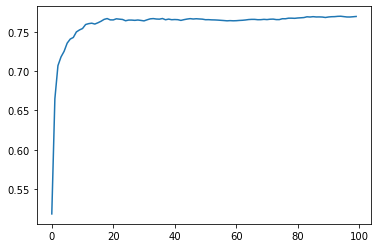

In [44]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(100)]);

可以看到，在用20颗左右的树之后，增加树的数量，对r-squere的结果就没有太大帮助了

## OOB

OOB(out-of-bag) score:

前面所说的bagging(打包)，不同的树使用随机的输入；

oob score就是，在计算测试集的error时，每棵树只选择训练时未被选中的那部分数据，相当于包含在测试集中的validation data

当训练集数据量较少，单独分出validation set会导致训练不足时，也可以用这种方法

> 这里还是有些迷糊的  
计算score的时候，应该是把整个forest作为一个模型去计算f的吧
那么oob score的输入是怎么选的？ 要求所有的树都没有使用这条数据进行训练么？ 那不就是验证集么？
或者说不是把forest作为整个模型，每颗树选择的输入都不同，那最终的f怎么得到呢？不应该是所有树结果的均值么？
视频中的说法是，不同的树用不同的数据计算，然后把这些结果求平均，得到obb score

In [56]:
m3 = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m3.fit(X_train, y_train)
print_score(m3)

Wall time: 4 s
[0.09245785500720259, 0.35776686947082664, 0.9813845724087107, 0.7714147433964127, 0.8651831302387963]


上面的输出中，最后一个是oobscore，可以看到它的值介于测试集的score和验证集的score之间

> 这个和视频中展示的不同，视频中oob score甚至比 valid set的score稍小一点   
可能和数据量有关，后面使用大量数据的情况，oob比valid小一丢丢，据说一般是这种情况。树的数量越多，结果越接近



> 增加这个参数后，验证集的score有一丢丢提升。  
为什么会有提升？ 理论上只是增加了个评价标准，并没有影响树的生成。  
当然这个提升也并不明显。由于数据是随机选的，多次运行得到的score在1%上下浮动。  
运行时间到是显著增加了

OOB score是调正超参的重要依据

## 减少过拟合

**首先我们用测试集的所有数据再跑一遍，方便后面对比效果**

In [57]:
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [63]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((389125, 66), (389125,), (12000, 66), (12000,))

In [64]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 3min 8s
[0.07573459822159995, 0.2364099127917242, 0.9880126419440564, 0.9001887856247848, 0.9128652804152524]


### 方法1：Subsampling

基本思路：限制每颗树输入数据的数量，并且保证每棵树随到不同的数据，那么在使用足够多颗树的情况下，是可以看到测试集中所有的数据的    
同时还能减少训练时间

In [66]:
set_rf_samples(20000)  #控制每个树的输入样本数量

In [67]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 3min 24s
[0.07582903131738004, 0.2363407545452055, 0.9879827293518535, 0.900247173691815, 0.9127588590153617]


In [68]:
m = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 1min 39s
[0.07755042244116728, 0.23642768452613463, 0.9874309295094958, 0.9001737787661969, 0.9097784955449063]


In [70]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

C:\Users\kongxiangyu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Wall time: 19.7 s
[0.09054096561239536, 0.2535534285462015, 0.9828673292084723, 0.8851880881501271, -1.2431719994052015]


可以看到树的数量对效果是有影响的，但是50-100并没有太大差别

> 有点怀疑set_rf_samples是否还能起到课程上说的作用。 因为树的数量是10的时候，已经出告警了。   
运行时间也不像课程里说的会减少，并没有显著变化
后面再详细研究

In [69]:
??set_rf_samples

### 方法2.修改各种超参

In [71]:
reset_rf_samples() #还原

#### min_samples_leaf

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [72]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

上面函数，实现了遍历获取树的深度

In [74]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 1min 5s
[0.07842683110401216, 0.23835342931898904, 0.9871452344325385, 0.8985409518863835, 0.9085100051584507]


In [77]:
t=m.estimators_[0].tree_
dectree_max_depth(t)

45

In [83]:
t=[m.estimators_[i].tree_ for i in range(40)]
depth = [dectree_max_depth(tt) for tt in t]

In [90]:
print(depth)
max(depth)

[45, 51, 46, 45, 44, 52, 48, 48, 46, 48, 46, 47, 46, 46, 49, 47, 46, 50, 47, 49, 46, 50, 46, 47, 49, 46, 45, 47, 48, 44, 46, 47, 48, 46, 47, 46, 53, 50, 47, 48]


53

`min_samples_leaf`表示每个叶子里最少的数据个数，默认是1，通过修改这个，可以减少树的深度  
常见的参数有1， 3， 5， 10 ，25等；如果训练数据量很大，这个值也可以设置很大(比如1000)

In [91]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 1min 13s
[0.14059507862172455, 0.23393663493650746, 0.958688110022044, 0.9022662751546815, 0.9070951272852408]


In [92]:
depth = [dectree_max_depth(m.estimators_[i].tree_) for i in range(40)]
print(depth, max(depth))

[36, 37, 39, 35, 39, 38, 38, 37, 37, 38, 38, 37, 37, 37, 37, 36, 37, 35, 38, 40, 38, 39, 36, 37, 36, 36, 37, 37, 37, 38, 37, 36, 37, 35, 35, 37, 36, 36, 38, 37] 40


`min_samples_leaf`设置成5，可以看到树的深度变小了，测试集的r-score有一丢丢改善  
时间并没有优化

In [94]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=25, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 59.6 s
[0.2066306126002002, 0.24542269528909635, 0.9107672756427797, 0.8924334061651451, 0.8923276124803247]


In [95]:
depth = [dectree_max_depth(m.estimators_[i].tree_) for i in range(40)]
print(depth, max(depth))

[27, 29, 29, 29, 28, 31, 27, 30, 28, 29, 29, 27, 29, 30, 27, 28, 28, 28, 27, 30, 28, 27, 27, 28, 28, 28, 30, 27, 27, 28, 29, 28, 28, 27, 28, 27, 28, 28, 28, 28] 31


#### max_features

使用`max_features`,在计算树的每一个分支时，随机的使用不同的列
> 注意这个和前面`set_rf_samples`的作用域是不同的，这里是对树的每一个分支取不同的随机列

In [96]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 39.7 s
[0.14466983290519936, 0.2304217584670692, 0.9562587906888349, 0.9051810924665435, 0.9100651284613783]


性能有提升，效果没有大差别

# 就到这里了，下一课继续